# Visualize financial inclusion in 3D

In this tutorial, I will show you how to visualize spatial distribution of financial inclusion in 3D using an interpolation technique called TIN (Triangular Interpolation Networks).
This analysis should be helpful to policymakers, banks and other providers of financial services aiming to target and expand their products to a broad range of people in order to achieve financial inclusion.

Dataset comes from the latest survey of demands for financial services ordered by FINSCOPE and executed by INSTAT. This survey concerns around 5000 respondents aged 18+ randomly selected within households.

First thing, we need is to build an indicator of financial inclusion. To do so, I have chosen the following questions:

 * Do respondents hold an account from any financial institution? 
 
 * Do respondents hold a mobile money account? 
 
 * How respondents save ? 
 
 * How respondents borrow ? 
 
 * Face of an unexpected expenses, Do they use financial services available to them? 
 
 * What kinds of payment they receive?
 
 * What kinds of payment they make ?
 
 * Do they transfer within the country?
 
 * Do they experience difficulties to access financial services? 
 
These questions were chosen to capture usage and access to financial services, financial literacy but also resilience to fullfill everyday needs and losses.

Further,in order to simplify index construction, I decided to attribute an arbritrarily chosen score for each variable responses. This is based on what I've known on the field so may be subject to change in the future as well as the weighting scheme itself.
 

## Load libraries we'll use:

In [1]:
import rpy2
from shapely.geometry import mapping, shape, Polygon, Point
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import rtree
from geopandas.tools import sjoin
import sys  
reload(sys)  
sys.setdefaultencoding('latin-1')
%matplotlib inline
%load_ext rpy2.ipython

## Convert latitude longitude into degree from within R

In [2]:
%%R
require(haven)
mypath="/media/herimanitra/DONNEES/TBE/"
X=read_dta(paste0(mypath,"finscope2015.dta"))
# lat lon variables: a141 to a146
#Convert long lat into degree:
X$latitude= -1*(X$a141 + X$a142/60 + X$a143/3600)
X$longitude = X$a144 + X$a145/60 + X$a146/3600
X=X[complete.cases(X$longitude,X$latitude),]

### Prepare variables to identify respondents

In [3]:
%%R
myvar= grep("^a18e",names(X),value=T)
for ( j in myvar) {
    X[, j:=ifelse( get(j)=="NaN",0,get(j)),with=F]
}
X[,tmp:=apply(X[,myvar,with=F],1,sum)]
X=X[tmp>0,]
X[,tmp:=NULL]
dim(X)

[1] 5009 1554


# Construction of Financial Inclusion Indicator

### Financial literacy score:

In [4]:
######################FINANCIAL LITERACY ###########################
# g4a** : Have they heard about the following insurance products
#modalities : 1 if yes, 2 if not 
#score 1 if 1, 0 if 2 
###################################################################

In [5]:
%%R
myvar= grep("^g4a",names(X),value=T)
for ( j in myvar )
    {
    X[, j:=ifelse( get(j)==2,0,1),with=F]
}
#convert NA::0
for ( j in myvar ) {
        X[,j:=ifelse( is.na(get(j)),0,get(j)),with=F]
}
X[,financial_literacy:=apply(X[,myvar,with=F],1,sum)]
table(X$financial_literacy)


   1    2    3    4    5    6    7    8    9   10   11   12 
1077 1235  415  338  234  188  111  108   53   97    9 1144 


### Financial resilience score:

In [6]:
############################# Financial resilience #################################################
# c15a: Yes/No (Do they plan to have major expenses in the next 12 months)
# score for c15a: 1 if yes 0 if not
# c15b5: Do they plan to contract loans into the bank
# score for c15b5: +2 if yes 0 if not
# g2*: action taken following an unexpected losses/events
# modalities 1, 2 and 6 make use of insurance products and savings (+1 for eahc of these modalities)
# g4b* : Do they subscribe to the insurance products mentioned in question g4a* (insurance coverage)
#####################################################################################################

In [7]:
%%R
X[,c15a:=ifelse(c15a==2,0,1)]
X[,c15b5:=ifelse(c15b5==1,2,0)]
myvar1= grep("^g2",names(X),value=T)
for ( j in myvar1 ) {
    X[,j:=ifelse( get(j) %in% c(1,2,6),1,0),with=F]
}
myvar2= grep("g4b",names(X),value=T)
for ( j in myvar2 ) {
    X[,j:=ifelse( get(j)==3,1, ifelse(get(j)==4,0.5,0)),with=F]
}
myvar= c("c15a","c15b5",myvar1,myvar2)
#convert NA::0
for ( j in myvar ) {
        X[,j:=ifelse( is.na(get(j)),0,get(j)),with=F]
}
X[,financial_resilience:= apply(X[,myvar,with=F],1,sum)]
table(X$financial_resilience)


   0  0.5    1  1.5    2  2.5    3  3.5    4  4.5    5    6    7 
2578   25 2014   13  223    4  112    1   23    1    9    3    3 


### Access to financial services score for farm households:

In [8]:
###################### ACCESS to financial services ###############
# b12b8 ==> lack of loans to enhance farm activities (-1 )
# b12c8-c11 ==> contract loans to finance farm activities (+1)
###################################################################

In [9]:
%%R
X[,b12b8:=ifelse(b12b8==1,-1,0)]
X[,b12c8:=ifelse(b12c8==1,1,0)]
X[,b12c9:=ifelse(b12c9==1,1,0)]
X[,b12c10:=ifelse(b12c10==1,1,0)]
X[,b12c11:=ifelse(b12c11==1,1,0)]
X[,b12c14:=ifelse(b12c14==1,1,0)]
#convert NA::0
myvar=c("b12b8","b12c8","b12c9","b12c10","b12c11","b12c14")
for (j in myvar) {
   X[,j:= ifelse( is.na(get(j)),0,get(j)),with=F]
}
X[,access:= apply(X[,myvar,with=F],1,sum)]
table(X$access)


  -1    0    1    2 
 147 4656  201    5 


### Score of Usage of financial services

In [10]:
###################################Savings###########################
# d3b*: groupe d'épargne auquel le répondant appartient (Do they save?)
#####################################################################

############################### payment and/or tranfers they did ###
# c13b* : means of payment
# f3d* What kinds of transfers they make and by which means?
####################################################################

############################# payment received ####################
# c301 ==>c399 What kinds of payment received?
# f10d**==> by which means?
###################################################################

In [11]:
%%R
myvar1=grep("^d3b",names(X),value=T)
for ( j in myvar1)
    {
    X[,j:=ifelse( get(j)==1,2,0),with=F]
    X[,j:=ifelse( is.na(get(j)),0,get(j) ),with=F]
}
myvar2= c("c13b1","c13b2","c13b6")
for ( j in myvar2)
    {
    X[,j:=ifelse( get(j)==1,1,0),with=F]
    X[,j:=ifelse( is.na(get(j)),0,get(j) ),with=F]
}
myvar3=grep("^f3d",names(X),value=T)
for ( j in myvar3)
    {
    X[,j:=ifelse( get(j) %in% c(1,2,5,6,7,8),1,0),with=F]
    X[,j:=ifelse( is.na(get(j)),0,get(j) ),with=F]
}
myvar4=grep("^c3",names(X),value=T)
for ( j in myvar4)
    {
    X[,j:=ifelse( get(j) %in% c(2,4),1,0),with=F]
    X[,j:=ifelse( is.na(get(j)),0,get(j) ),with=F]
}
myvar5=grep("^f10d",names(X),value=T)
for ( j in myvar5)
    {
    X[,j:=ifelse( get(j) %in% c(1,2,4,6,7,8,9),1,0),with=F]
    X[,j:=ifelse( is.na(get(j)),0,get(j) ),with=F]
}
myvar=c(myvar1,myvar2,myvar3,myvar4,myvar5)
X[,usage:= apply(X[,myvar,with=F],1,sum)]
table(X$usage)


   0    1    2    3    4    5    6    7 
4122  488  263   91   35    7    2    1 


### Final score

In [12]:
%%R
X[,score:=financial_literacy + financial_resilience + access + usage]
summary(X$score)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   4.000   5.974  11.000  22.000 


#### save data

In [13]:
%%R
myvar=c("longitude","latitude","financial_literacy","financial_resilience","access","usage","score")
write.table(X[,myvar,with=F],paste0(mypath,"finscope2015.csv"),sep=";",row.names = F)

In [14]:
# a10 ==> rural/ruban

## Load csv file into python:

In [15]:
mypath="/media/herimanitra/DONNEES/TBE/"
finscope=pd.read_csv(mypath+"finscope2015.csv",sep=";")

## convert csv file into geodataframe

In [16]:
finscope['geometry'] = finscope.apply(lambda z: Point(z.longitude,z.latitude ), axis=1)
finscope_pointgeod = gpd.GeoDataFrame(finscope)

## Load base shapefile of Madagascar

In [17]:
path_to_shapefile = '/media/herimanitra/DONNEES/TBE/mdg/MDG_adm3.shp'
df = GeoDataFrame.from_file(path_to_shapefile)

### Ensure that csv file and shapefile both have the same projection

In [18]:
finscope_pointgeod.crs = df.crs

## Spatial join : points to polygons

In [19]:
df=sjoin(df, finscope_pointgeod,how='left', op='intersects')

### then save to shapefile for ArcGIS:

In [28]:
finscope_pointgeod_rectified=df[['longitude','latitude','score']]
finscope_pointgeod_rectified['geometry'] = finscope_pointgeod_rectified.apply(lambda z: Point(z.longitude,z.latitude ), axis=1)
finscope_pointgeod_rectified = gpd.GeoDataFrame(finscope_pointgeod_rectified)

In [29]:
mypath="/media/herimanitra/DONNEES/TBE/MDG-FINSCOPE/"
finscope_pointgeod_rectified.to_file(mypath + "finscope.shp", driver='ESRI Shapefile')

### Convert lat/long to float:

In [37]:
#convert to float:
df.latitude = df.latitude.astype(float)
df.longitude = df.longitude.astype(float)

## Spatial distribution of the sample 

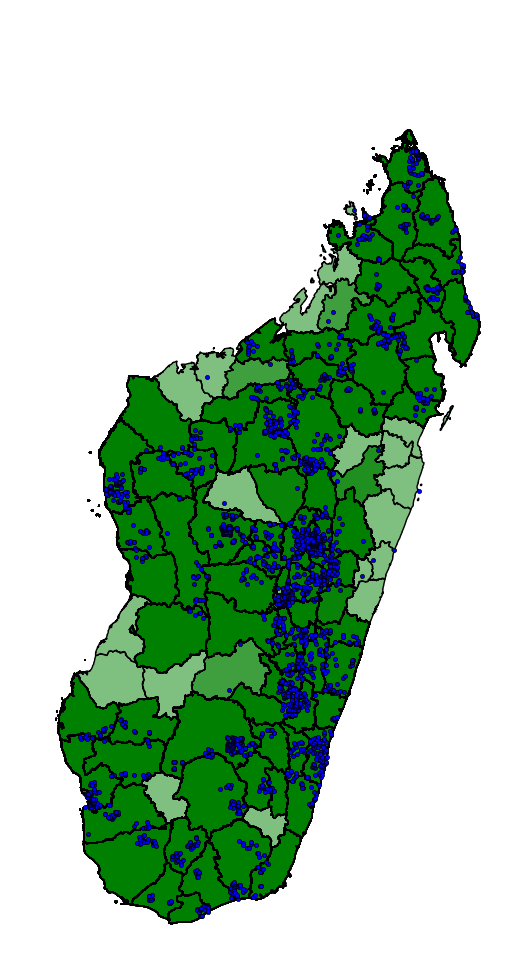

In [38]:
#setup params for plotting
ax= df.plot(figsize=(12, 12),color='green')
#plot respondants
for x, y in zip(df['longitude'], df['latitude']):
    ax.plot(x, y, 'bo', markersize=3.)
ax.plot()
ax.set_axis_off()

We can see that sampling techniques ensure households are well enough distributed across the island even if we notice small under representation of people from the South West Coast.
Human errors (surveyors) decrease sample points from which I can exploit GPS data and reduce the sample points to around 3000.

## Save map

In [40]:
fig = ax.get_figure()
fig.savefig('/media/herimanitra/DONNEES/TBE/finscope_points.png')

# Steps to implement TIN in ArcGIS

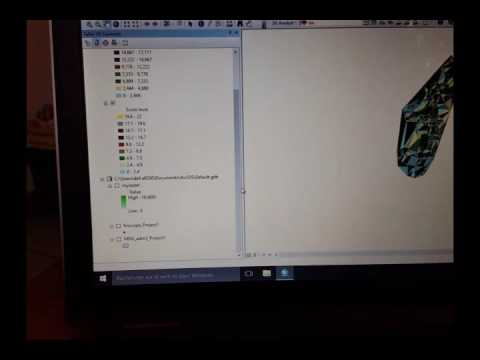

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo("goabGuOwxJg")